In [1]:
import numpy as np
import brainlit
import scipy
from brainlit.utils import swc
from cloudvolume.exceptions import SkeletonDecodeError
from brainlit.algorithms.trace_analysis.fit_spline import GeometricGraph
from brainlit.algorithms.trace_analysis.spline_fxns import curvature, torsion
import os
from pathlib import Path
import pandas as pd
from networkx.readwrite import json_graph
import json
import matplotlib.pyplot as plt
import seaborn as sns

/cis/home/jteneggi/anaconda3/envs/cuda10/lib/python3.8/site-packages/python_jsonschema_objects/__init__.py:50: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  warnings.warn(


## Define brain, find trace data folder

In [2]:
#specify brain1 or brain2 below
brain = "brain2"

root_dir = Path(os.path.abspath('')).parents[1]
experiment_dir = os.path.join(root_dir, "axon_geometry")
data_dir = os.path.join(experiment_dir, "data", brain)
segments_swc_dir = os.path.join(data_dir, "segments_swc")
trace_data_dir = os.path.join(data_dir, "trace_data")
trace_data_dir = os.path.join(trace_data_dir, "14")
print(f"Directory where swcs reside: {segments_swc_dir}")

Directory where swcs reside: /cis/home/jteneggi/repo/brainlit/experiments/axon_geometry/data/brain2/segments_swc


## Read trace data

In [3]:
max_id = 300
seg_lengths = []
mean_torsions = []
mean_curvatures = []
d_from_root = []
torsions = []
curvatures = []

def classify_height(row):
    height = row["height"]
    if height <= 2:
        return height
    else:
        return 3

df_path = os.path.join(trace_data_dir, "df.csv")
if os.path.exists(df_path):
    df = pd.read_csv(df_path)
else:
    df = pd.DataFrame(columns=["seg_id", "height", "log_segment_length", "measure", "log_value"])
    for i in np.arange(0, max_id):
        i = int(i)
        trace_data_path = os.path.join(trace_data_dir, "{}.npy".format(i))
        if os.path.exists(trace_data_path) is True:
            trace_data = np.load(trace_data_path, allow_pickle=True)
            print("Loaded segment {}".format(i))

            for node in trace_data:
                # print(node)
                seg_length = node["seg_length"]
                height = node["height"]
                mean_curvature = node["mean_curvature"]
                mean_torsion = node["mean_torsion"]
                log_seg_length = np.log10(seg_length)
                if mean_curvature > 1e-16:
                    log_mean_curvature = np.log10(mean_curvature)
                    df = df.append({"seg_id": i, "height": height, "log_seg_length": log_seg_length, "measure": "curvature", "log_value": log_mean_curvature}, ignore_index=True)
                if mean_torsion > 1e-16:
                    log_mean_torsion = np.log10(mean_torsion)
                    df = df.append({"seg_id": i, "height": height, "log_seg_length": log_seg_length, "measure": "torsion", "log_value": log_mean_torsion}, ignore_index=True)
    df.to_csv(df_path)
df["height_class"] = df.apply(classify_height, axis=1)

Loaded segment 1
Loaded segment 2
Loaded segment 4
Loaded segment 5
Loaded segment 7
Loaded segment 9
Loaded segment 10
Loaded segment 11
Loaded segment 12
Loaded segment 13
Loaded segment 14
Loaded segment 15
Loaded segment 16
Loaded segment 17
Loaded segment 20
Loaded segment 21
Loaded segment 23
Loaded segment 31
Loaded segment 32
Loaded segment 33
Loaded segment 34
Loaded segment 35
Loaded segment 37
Loaded segment 38
Loaded segment 39
Loaded segment 40
Loaded segment 41
Loaded segment 42
Loaded segment 43
Loaded segment 44
Loaded segment 45
Loaded segment 47
Loaded segment 48
Loaded segment 49
Loaded segment 51
Loaded segment 52
Loaded segment 53
Loaded segment 54
Loaded segment 55
Loaded segment 56
Loaded segment 57
Loaded segment 58
Loaded segment 59
Loaded segment 60
Loaded segment 61
Loaded segment 62
Loaded segment 63
Loaded segment 64
Loaded segment 65
Loaded segment 66


# Density of `log` segment lengths as a function of spline height

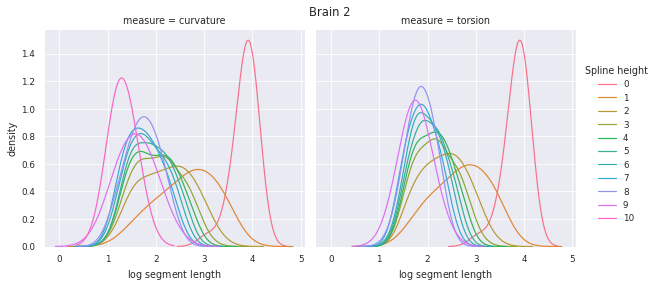

In [4]:
sns.set_theme()
sns.set_context("paper")

g = sns.FacetGrid(df, col="measure", hue="height", height=4)
g.map(sns.kdeplot, "log_seg_length", bw_adjust=1.8)
g.set_axis_labels(r"$\log$ segment length", "density")
g.add_legend(title="Spline height")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Brain 1" if brain=="brain1" else "Brain 2")
g.savefig(os.path.join(experiment_dir, "figures",  f"{brain}_seg_length_height_density.eps"))
g.savefig(os.path.join(experiment_dir, "figures", f"{brain}_seg_length_height_density.jpg"))

# Density of `log` segment lengths as a function of spline height class

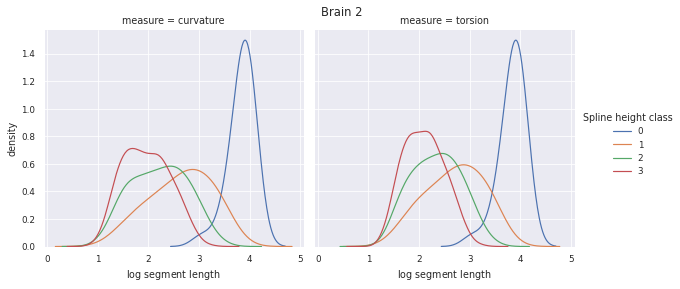

In [5]:
sns.set_theme()
sns.set_context("paper")

g = sns.FacetGrid(df, col="measure", hue="height_class", height=4)
g.map(sns.kdeplot, "log_seg_length", bw_adjust=1.8)
g.set_axis_labels(r"$\log$ segment length", "density")
g.add_legend(title="Spline height class")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Brain 1" if brain=="brain1" else "Brain 2")
g.savefig(os.path.join(experiment_dir, "figures",  f"{brain}_seg_length_height_class_density.eps"))
g.savefig(os.path.join(experiment_dir, "figures", f"{brain}_seg_length_height_class_density.jpg"))

# Density of `log` curvature/torsion as a function of spline height class

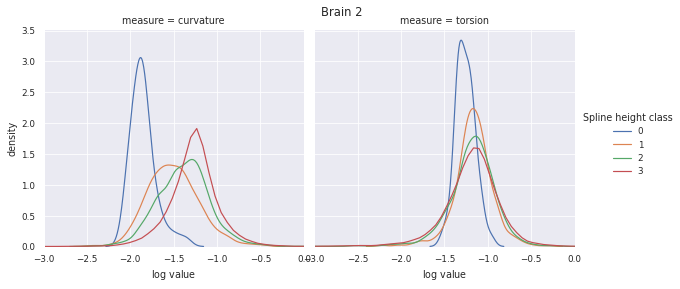

In [6]:
g = sns.FacetGrid(df, col="measure", hue="height_class", height=4)
g.map(sns.kdeplot, "log_value")
g.set_axis_labels(r"$\log$ value", "density")
g.add_legend(title="Spline height class")
g.set(xlim=[-3, 0])
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Brain 1" if brain=="brain1" else "Brain 2")
g.savefig(os.path.join(experiment_dir, "figures",  f"{brain}_mean_value_height_class_density.eps"))
g.savefig(os.path.join(experiment_dir, "figures", f"{brain}_mean_value_height_class_density.jpg"))

# Scatter plots of `log` curvature/torsion as a function of spline height class

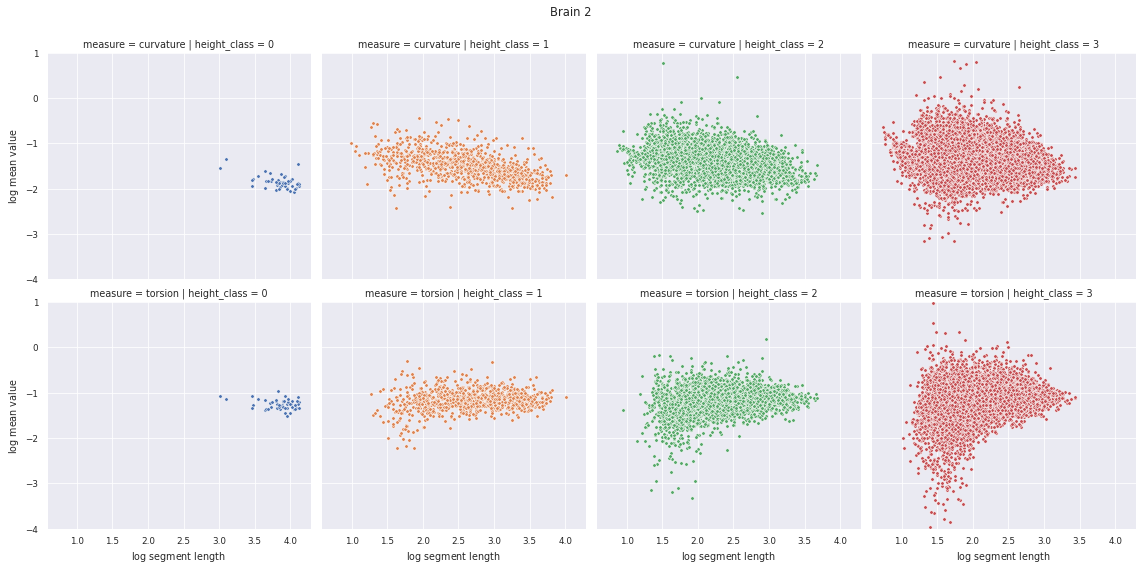

In [7]:
g = sns.FacetGrid(df, row="measure", col="height_class", hue="height_class", height=4)
g.map(sns.scatterplot, "log_seg_length", "log_value", marker='.', s=50)
g.set_axis_labels(r"$\log$ segment length", r"$\log$ mean value")
g.set(ylim=[-4, 1])
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Brain 1" if brain=="brain1" else "Brain 2")
g.savefig(os.path.join(experiment_dir, "figures",  f"{brain}_mean_value_height_class_scatter.eps"))
g.savefig(os.path.join(experiment_dir, "figures", f"{brain}_mean_value_height_class_scatter.jpg"))

# Linear regression of `log` curvature/torsion as a function of spline height class

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

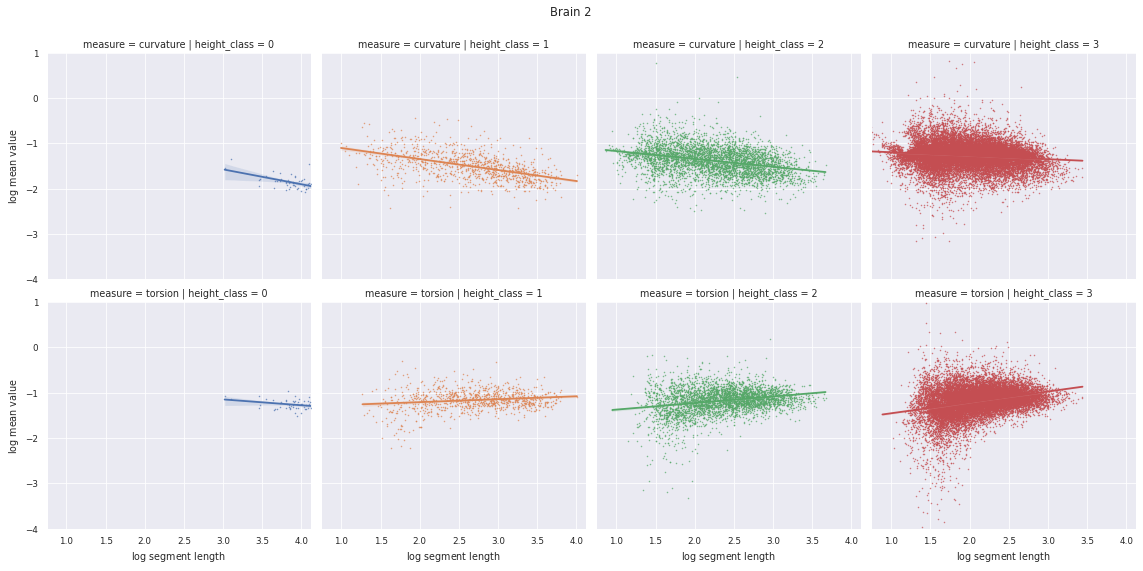

In [8]:
g = sns.FacetGrid(df, row="measure", col="height_class", hue="height_class", height=4)
g.map(sns.regplot, "log_seg_length", "log_value", marker='.', scatter_kws={'s':1})
g.set_axis_labels(r"$\log$ segment length", r"$\log$ mean value")
g.set(ylim=[-4, 1])
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Brain 1" if brain=="brain1" else "Brain 2")
g.savefig(os.path.join(experiment_dir, "figures",  f"{brain}_liear_regression_height_class.eps"))
g.savefig(os.path.join(experiment_dir, "figures", f"{brain}_linear_regression_height_class.jpg"))